In [1]:
import pickle
import os
import numpy as np
import time

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

def load_dataset(source, imbalance = True):
    DIR = os.getcwd()
    if source == 'STEAD':
        data_path = os.path.join(DIR, 'labeled_dump_STEAD')
    if source == 'PUSAN':
        data_path = os.path.join(DIR, 'labeled_dump')
        
    data_list = sorted(os.listdir(data_path))
    
    if imbalance == False:
        index = 1
    else:
        index = 0
        
    for idx, data in enumerate(data_list[index:index+1]):
        with open(os.path.join(data_path, data), 'rb') as f:
            if idx == 0:
                dataset = pickle.load(f)
            else:
                dataset = np.concatenate((dataset, pickle.load(f)))

    print('DEVICE \t\t: ', DEVICE)
    print('pid \t\t: ', os.getpid())

    print('\n---------------------------------Data---------------------------------\n')

    class SeismicDataset(Dataset): 
        def __init__(self, xs, ys):
            self.x_data = xs
            self.y_data = ys

        def __len__(self): 
            return len(self.x_data)

        def __getitem__(self, idx): 
            x = self.x_data[idx]
            y = self.y_data[idx]
            return x, y

    def make_x_p_s(dataset):
        
        x = np.array([dataset[i]['data'].T for i in range(len(dataset))])
        y_p = np.array([dataset[i]['p_label'] for i in range(len(dataset))])[:,np.newaxis]
        y_s = np.array([dataset[i]['s_label'] for i in range(len(dataset))])[:,np.newaxis]
        
        t_count = [dataset[i]['p_label'] for i in range(len(dataset))].count(1)
        f_count = [dataset[i]['p_label'] for i in range(len(dataset))].count(0)
        
        print('data length \t: ', len(dataset))
        print('True count \t:', t_count)
        print('False count \t:', f_count)
        print('T/F ratio \t:', 100*t_count/(t_count+f_count), '%')
        print()


        return torch.as_tensor(x.astype(np.float32)), torch.as_tensor(y_p.astype(np.float32)), torch.as_tensor(y_s.astype(np.float32))

    def train_test_valid_split(dataset):
        train, test = train_test_split(dataset, 
                                       test_size=0.3, 
                                       shuffle=True, 
                                       random_state=1004)
        valid = test[int(0.25*len(test)):]
        test = test[:int(0.25*len(test))]

        return train, test, valid

    x, y_p, y_s = make_x_p_s(dataset)

    train_x, valid_x, test_x  = train_test_valid_split(x)
    train_y_p, valid_y_p, test_y_p  = train_test_valid_split(y_p)
    train_y_s, valid_y_s, test_y_s = train_test_valid_split(y_s)

    print('Train size \t:',  len(train_x))
    print('Valid size \t:', len(valid_x))
    print('Test size \t:', len(test_x))
    print()
    print('x shape \t:', x.shape)
    print('y_p shape \t:',y_p.shape)

    print('\n------------------------------Data Loader------------------------------\n')

    train_loader = DataLoader(
        dataset=SeismicDataset(train_x, train_y_p), batch_size=500, shuffle=True
    )
    valid_loader = DataLoader(
        dataset=SeismicDataset(test_x, test_y_p), batch_size=500, shuffle=True
    )
    test_loader = DataLoader(
        dataset=SeismicDataset(valid_x, valid_y_p), batch_size=500, shuffle=True
    )

    for (X_train, y_train) in train_loader : 
        print('X_train : ', X_train.size() , ' \ttype : ', X_train.type())
        print('y_train : ', y_train.size() , ' \t\ttype : ', y_train.type())
        break
        
    
    return len(train_x), train_loader, valid_loader, test_loader

train_length, train_loader, valid_loader, test_loader = load_dataset('STEAD', imbalance=False)

DEVICE 		:  cuda:1
pid 		:  1014

---------------------------------Data---------------------------------

data length 	:  20000
True count 	: 10000
False count 	: 10000
T/F ratio 	: 50.0 %

Train size 	: 14000
Valid size 	: 1500
Test size 	: 4500

x shape 	: torch.Size([20000, 3, 6000])
y_p shape 	: torch.Size([20000, 1])

------------------------------Data Loader------------------------------

X_train :  torch.Size([500, 3, 6000])  	type :  torch.FloatTensor
y_train :  torch.Size([500, 1])  		type :  torch.FloatTensor


In [2]:
class CNNEncoder(nn.Module):
    def __init__(self):
        super(CNNEncoder, self).__init__()
        kernel_size = 200
        self.conv1 = nn.Conv1d(3, 4, kernel_size=kernel_size, padding=kernel_size//2)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(4, 8, kernel_size=(kernel_size-2), padding=(kernel_size-2)//2)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(8, 16, kernel_size=(kernel_size-4), padding=(kernel_size-4)//2)
        self.maxpool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv1d(16, 32, kernel_size=(kernel_size-6), padding=(kernel_size-6)//2)
        self.maxpool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.5)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(p=0.5)
        
        
        self.relu5 = nn.ReLU()
        self.relu6 = nn.ReLU()
        
        self.fc1 = nn.Linear(in_features=32 * 375, out_features=1500)
        self.fc2 = nn.Linear(in_features=1500, out_features= 100)
        self.fc3 = nn.Linear(in_features=100, out_features=1) 
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inp):
        inp = inp.to(DEVICE, dtype=torch.float)
        out = self.conv1(inp)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.maxpool1(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.maxpool2(out)
        
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        out = self.maxpool3(out)
        
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.dropout4(out)
        out = self.maxpool4(out)
        
        out = out.view(-1, 32 * 375)
        
        out = self.fc1(out)
        out = self.relu5(out)
        out = self.fc2(out)
        out = self.relu6(out)
        out = self.fc3(out)
#         out = torch.round(self.sigmoid(out))
        
        out = self.sigmoid(out)

#         out = self.softmax(out)
#         out = torch.argmax(out, 1)
        
        return out
    
def metric(test_outputs, test_y_p):
    cnt = 0
    TP = FP = TN = FN = 0 + sys.float_info.epsilon
    for idx in range(len(test_y_p)):
        if int(torch.round(test_outputs[idx])) == 1 and int(torch.round(test_y_p[idx])) == 1:
            TP += 1
        if int(torch.round(test_outputs[idx])) == 1 and int(torch.round(test_y_p[idx])) == 0:
            FP += 1
        if int(torch.round(test_outputs[idx])) == 0 and int(torch.round(test_y_p[idx])) == 0:
            TN += 1
        if int(torch.round(test_outputs[idx])) == 0 and int(torch.round(test_y_p[idx])) == 1:
            FN += 1
            
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = 2*(precision * recall)/(precision + recall)
    
    return accuracy, precision, recall, F1_score

def save_fig(model_name, epoch, plot_dict):
    DIR = os.getcwd()
    output_dir = os.path.join(DIR, 'outputs', model_name)
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
        
    plt.figure(figsize=(10, 5))
    plt.plot(plot_dict['losses'])
    plt.plot(plot_dict['val_losses'])
    plt.legend(['train', 'validation'], loc='upper right')
    plt.savefig(os.path.join(output_dir, model_name + '_' + str(epoch) + '_loss.png'))
    
    plt.figure(figsize=(10, 5))
    plt.plot(plot_dict['acc'])
    plt.plot(plot_dict['prec'])
    plt.plot(plot_dict['rec'])
    plt.plot(plot_dict['f1'])
    plt.legend(['val_accuracy', 'val_precision', 'val_recall', 'val_F1_score'], loc='lower right')
    plt.savefig(os.path.join(output_dir, model_name + '_' + str(epoch) + '_metric.png'))

 Epoch [1/100], Step [28/28], Loss: 0.8162, Val Loss: 0.5193 accuracy : 0.9660, precision : 0.9869, recall : 0.9417, F1_score : 0.9638
 Epoch [2/100], Step [28/28], Loss: 0.3865, Val Loss: 0.4632 accuracy : 0.9740, precision : 0.9959, recall : 0.9528, F1_score : 0.9738
 Epoch [3/100], Step [28/28], Loss: 0.5903, Val Loss: 0.3981 accuracy : 0.9720, precision : 0.9959, recall : 0.9488, F1_score : 0.9718
 Epoch [4/100], Step [28/28], Loss: 0.4496, Val Loss: 0.3152 accuracy : 0.9780, precision : 0.9888, recall : 0.9708, F1_score : 0.9797
 Epoch [5/100], Step [28/28], Loss: 0.8679, Val Loss: 0.4966 accuracy : 0.9700, precision : 0.9409, recall : 1.0000, F1_score : 0.9696
 Epoch [6/100], Step [28/28], Loss: 0.1830, Val Loss: 0.2717 accuracy : 0.9840, precision : 0.9775, recall : 0.9924, F1_score : 0.9849
 Epoch [7/100], Step [28/28], Loss: 0.9636, Val Loss: 0.5105 accuracy : 0.9800, precision : 0.9811, recall : 0.9811, F1_score : 0.9811
 Epoch [8/100], Step [28/28], Loss: 0.5215, Val Loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


 Epoch [81/100], Step [28/28], Loss: 0.4070, Val Loss: 0.0492 accuracy : 1.0000, precision : 1.0000, recall : 1.0000, F1_score : 1.0000
 Epoch [82/100], Step [28/28], Loss: 0.4419, Val Loss: 0.2631 accuracy : 0.9900, precision : 0.9848, recall : 0.9962, F1_score : 0.9905
 Epoch [83/100], Step [28/28], Loss: 0.0277, Val Loss: 0.7214 accuracy : 0.9820, precision : 1.0000, recall : 0.9614, F1_score : 0.9803
 Epoch [84/100], Step [28/28], Loss: 0.2081, Val Loss: 0.0951 accuracy : 0.9900, precision : 0.9912, recall : 0.9869, F1_score : 0.9891
 Epoch [85/100], Step [28/28], Loss: 0.4768, Val Loss: 0.4244 accuracy : 0.9900, precision : 0.9921, recall : 0.9881, F1_score : 0.9901
 Epoch [86/100], Step [28/28], Loss: 0.1218, Val Loss: 0.0411 accuracy : 0.9920, precision : 1.0000, recall : 0.9837, F1_score : 0.9918
 Epoch [87/100], Step [28/28], Loss: 0.2515, Val Loss: 0.0220 accuracy : 0.9960, precision : 0.9920, recall : 1.0000, F1_score : 0.9960
 Epoch [88/100], Step [28/28], Loss: 0.4155, Val

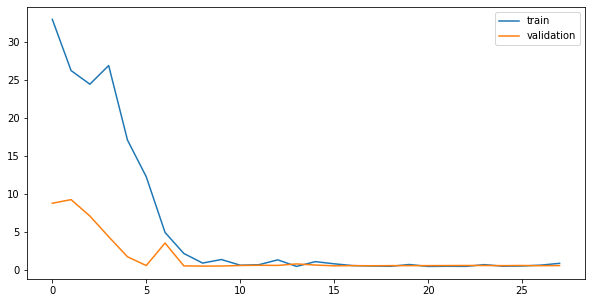

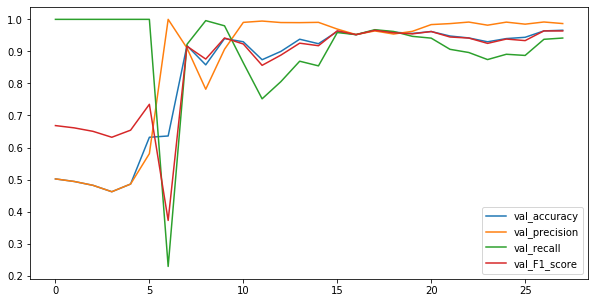

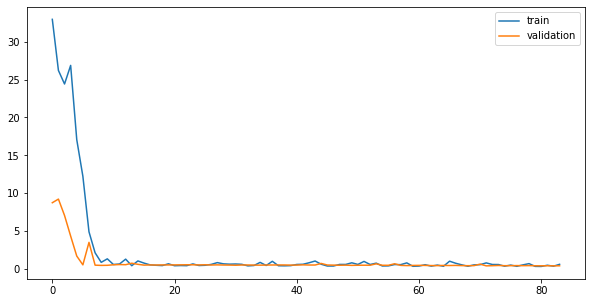

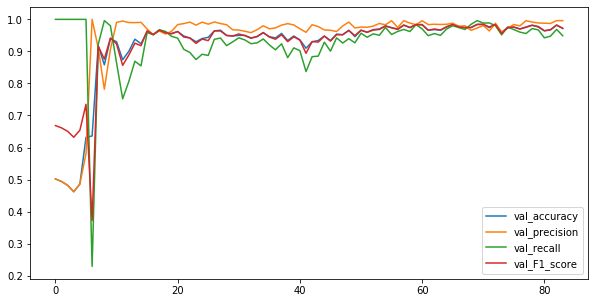

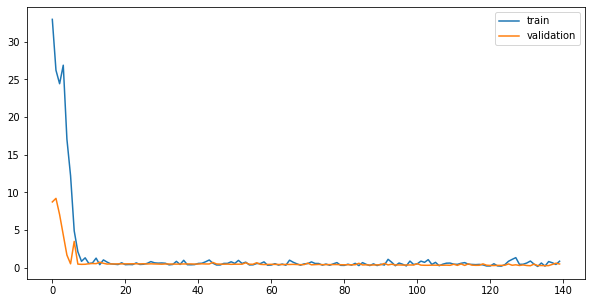

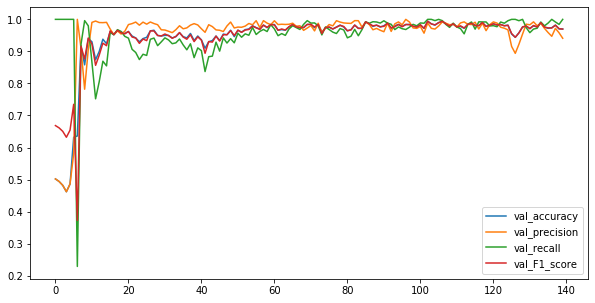

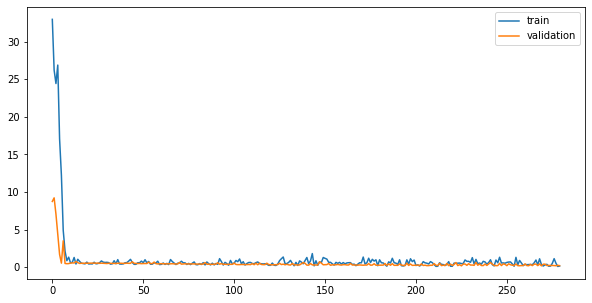

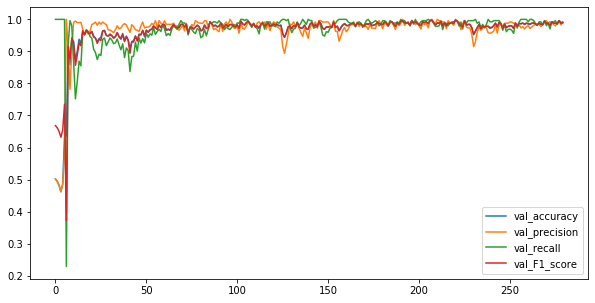

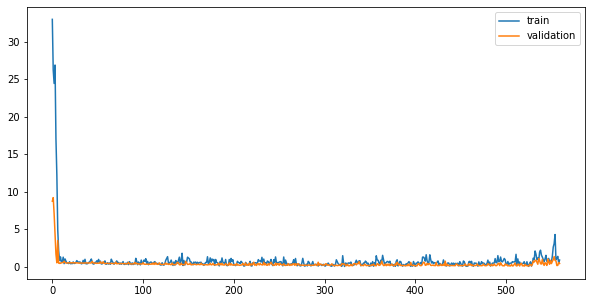

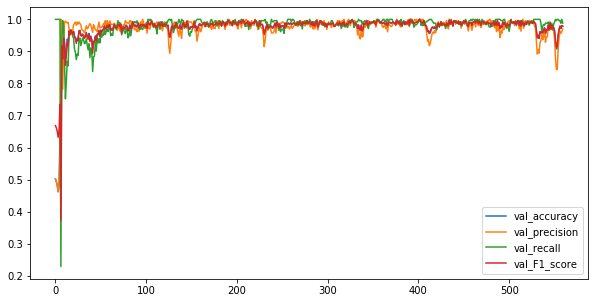

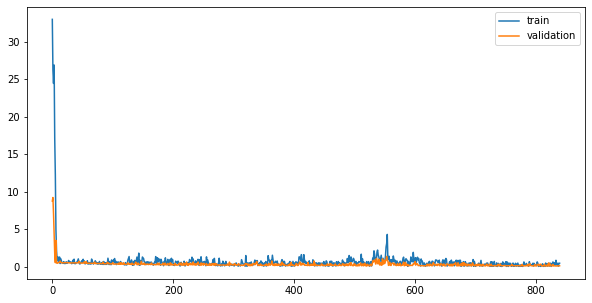

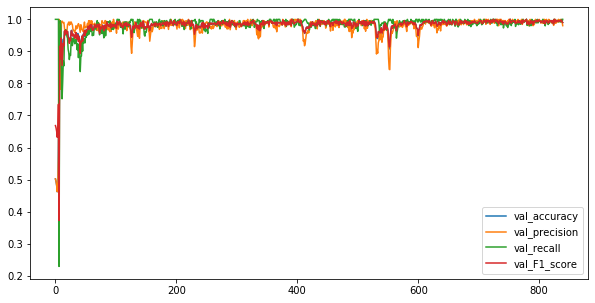

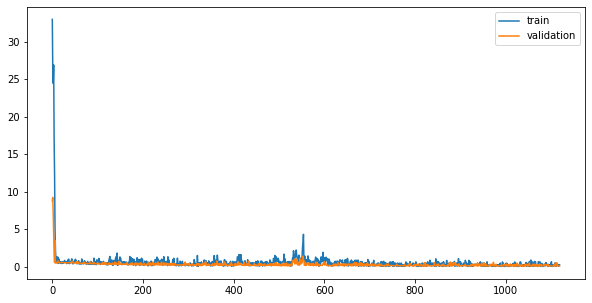

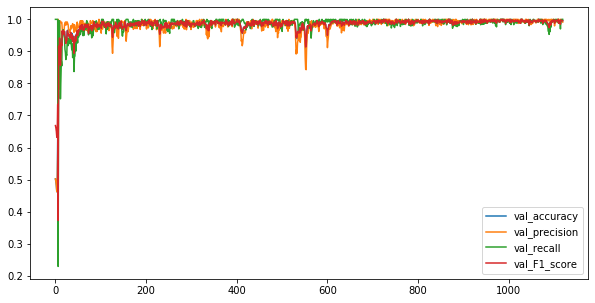

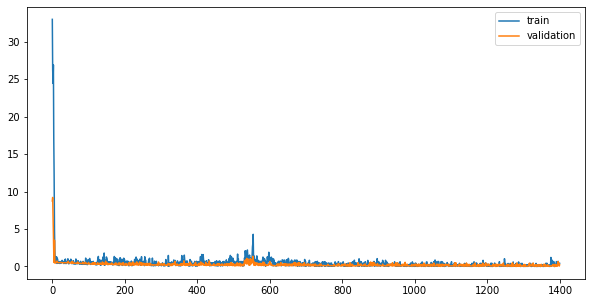

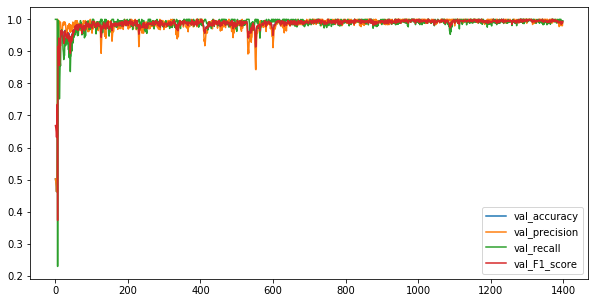

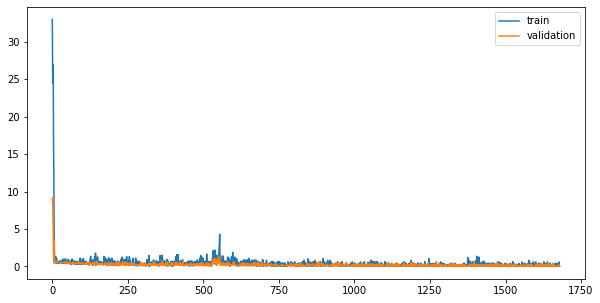

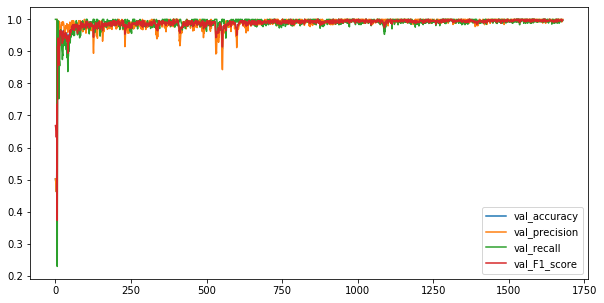

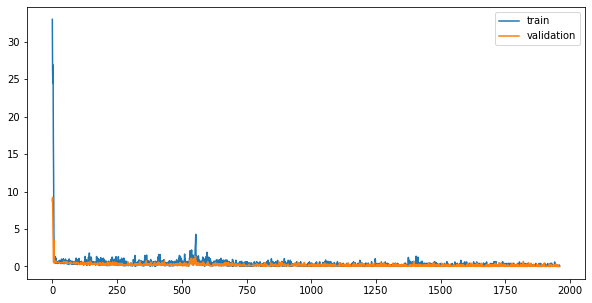

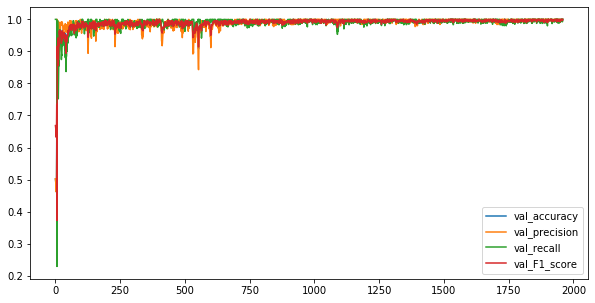

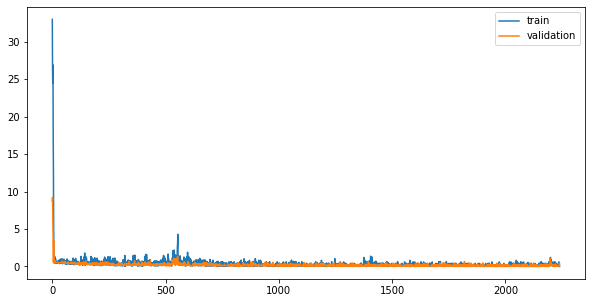

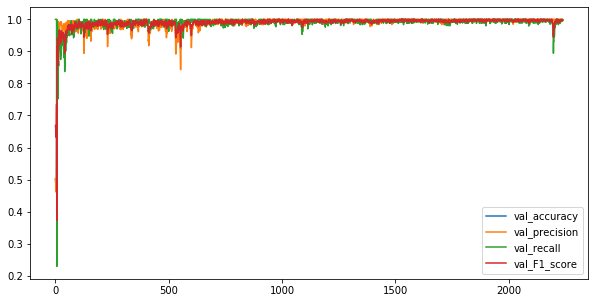

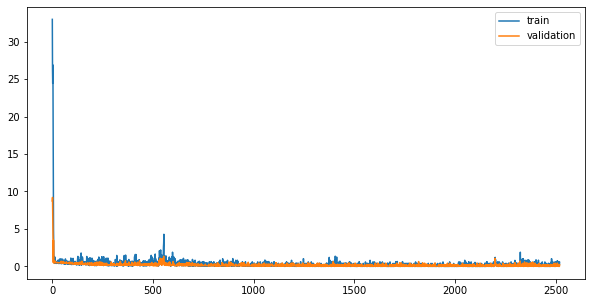

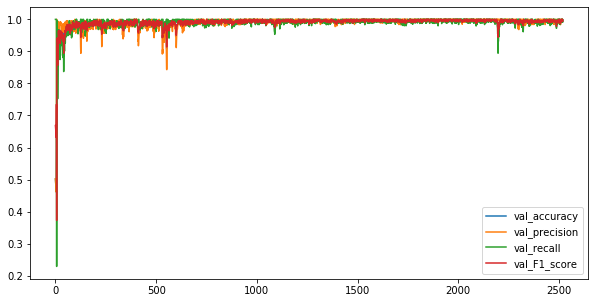

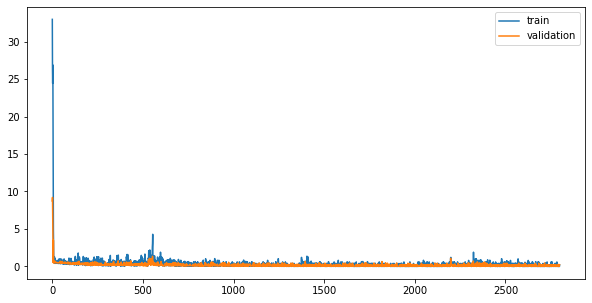

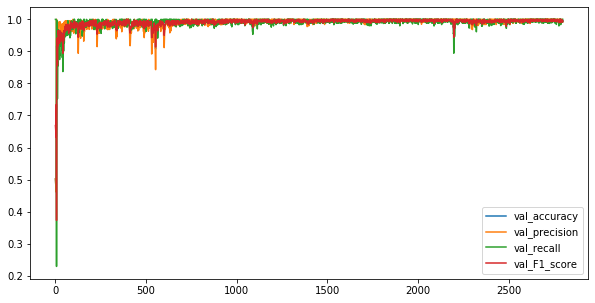

In [3]:
num_epochs = 100
total_step = train_length//500

encoder = CNNEncoder().to(DEVICE)

criterion = nn.BCELoss(reduction='mean')
params = list(encoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.0001)

plot_dict = dict()
losses = list()
val_losses = list()
acc = list()
prec = list()
rec = list()
f1 = list()

t0 = time.time()

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        encoder.train()
        encoder.zero_grad()
        
        inp, label = next(iter(train_loader))
        inp = inp.to(DEVICE)
        label = label.to(DEVICE)
        outputs = encoder(inp).to(DEVICE)
        loss = criterion(outputs, label)
        
        loss.backward()
        optimizer.step()
        
        # - - - Validate - - -
        with torch.no_grad():
            
            encoder.eval()

            val_inp, val_label = next(iter(valid_loader))
            val_inp = val_inp.to(DEVICE)
            val_label = val_label.to(DEVICE)
            val_outputs = encoder(val_inp).to(DEVICE)
            
            val_loss = criterion(val_outputs, val_label)
#             print('\n')
#             for i in range(10):
#                 print(torch.round(val_outputs[i]), val_label[i])
#                 print(torch.round(val_outputs[i]), torch.round(val_label[i]))
#                 print(int(val_outputs[i]), int(val_label[i]))
            val_accuracy, val_precision, val_recall, val_F1_score = metric(val_outputs, val_label)
#             break
        val_losses.append(val_loss.item())
        losses.append(loss.item())
        acc.append(val_accuracy)
        prec.append(val_precision)
        rec.append(val_recall)
        f1.append(val_F1_score)
        
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Val Loss: %.4f accuracy : %.4f, precision : %.4f, recall : %.4f, F1_score : %.4f' % \
                (epoch, num_epochs, i_step, total_step, loss.item(), val_loss.item(), val_accuracy, val_precision, val_recall, val_F1_score)
        
        print('\r', stats, end="")
        
#         f = sys.stdout
#         f = path
#         print(stats, 'Process in [%d/%d] step' % (i_step, total_step), file=f)
        
    print('\r', stats)
    
    plot_dict['val_losses'] = val_losses
    plot_dict['losses'] = losses
    plot_dict['acc'] = acc
    plot_dict['prec'] = prec
    plot_dict['rec'] = rec
    plot_dict['f1'] = f1
    
    if epoch == 1 or epoch == 3 or epoch == 5 or epoch%10 == 0:
        save_fig('balance', epoch, plot_dict)
    

t1 = time.time()

print('finished in {} seconds'.format(t1 - t0))

In [26]:
with torch.no_grad():
            
    encoder.eval()

    test_inp, test_label = next(iter(test_loader))
    test_inp = test_inp.to(DEVICE)
    test_label = test_label.to(DEVICE)
    test_outputs = encoder(test_inp).to(DEVICE)

    test_loss = criterion(test_outputs, test_label)
    test_accuracy, test_precision, test_recall, test_F1_score = metric(test_outputs, test_label)
        
stats = 'Loss: %.4f, accuracy : %.4f, precision : %.4f, recall : %.4f, F1_score : %.4f' % \
                (test_loss.item(), test_accuracy, test_precision, test_recall, test_F1_score)
        
print(stats)

Loss: 0.0193, accuracy : 0.9980, precision : 1.0000, recall : 0.9959, F1_score : 0.9980


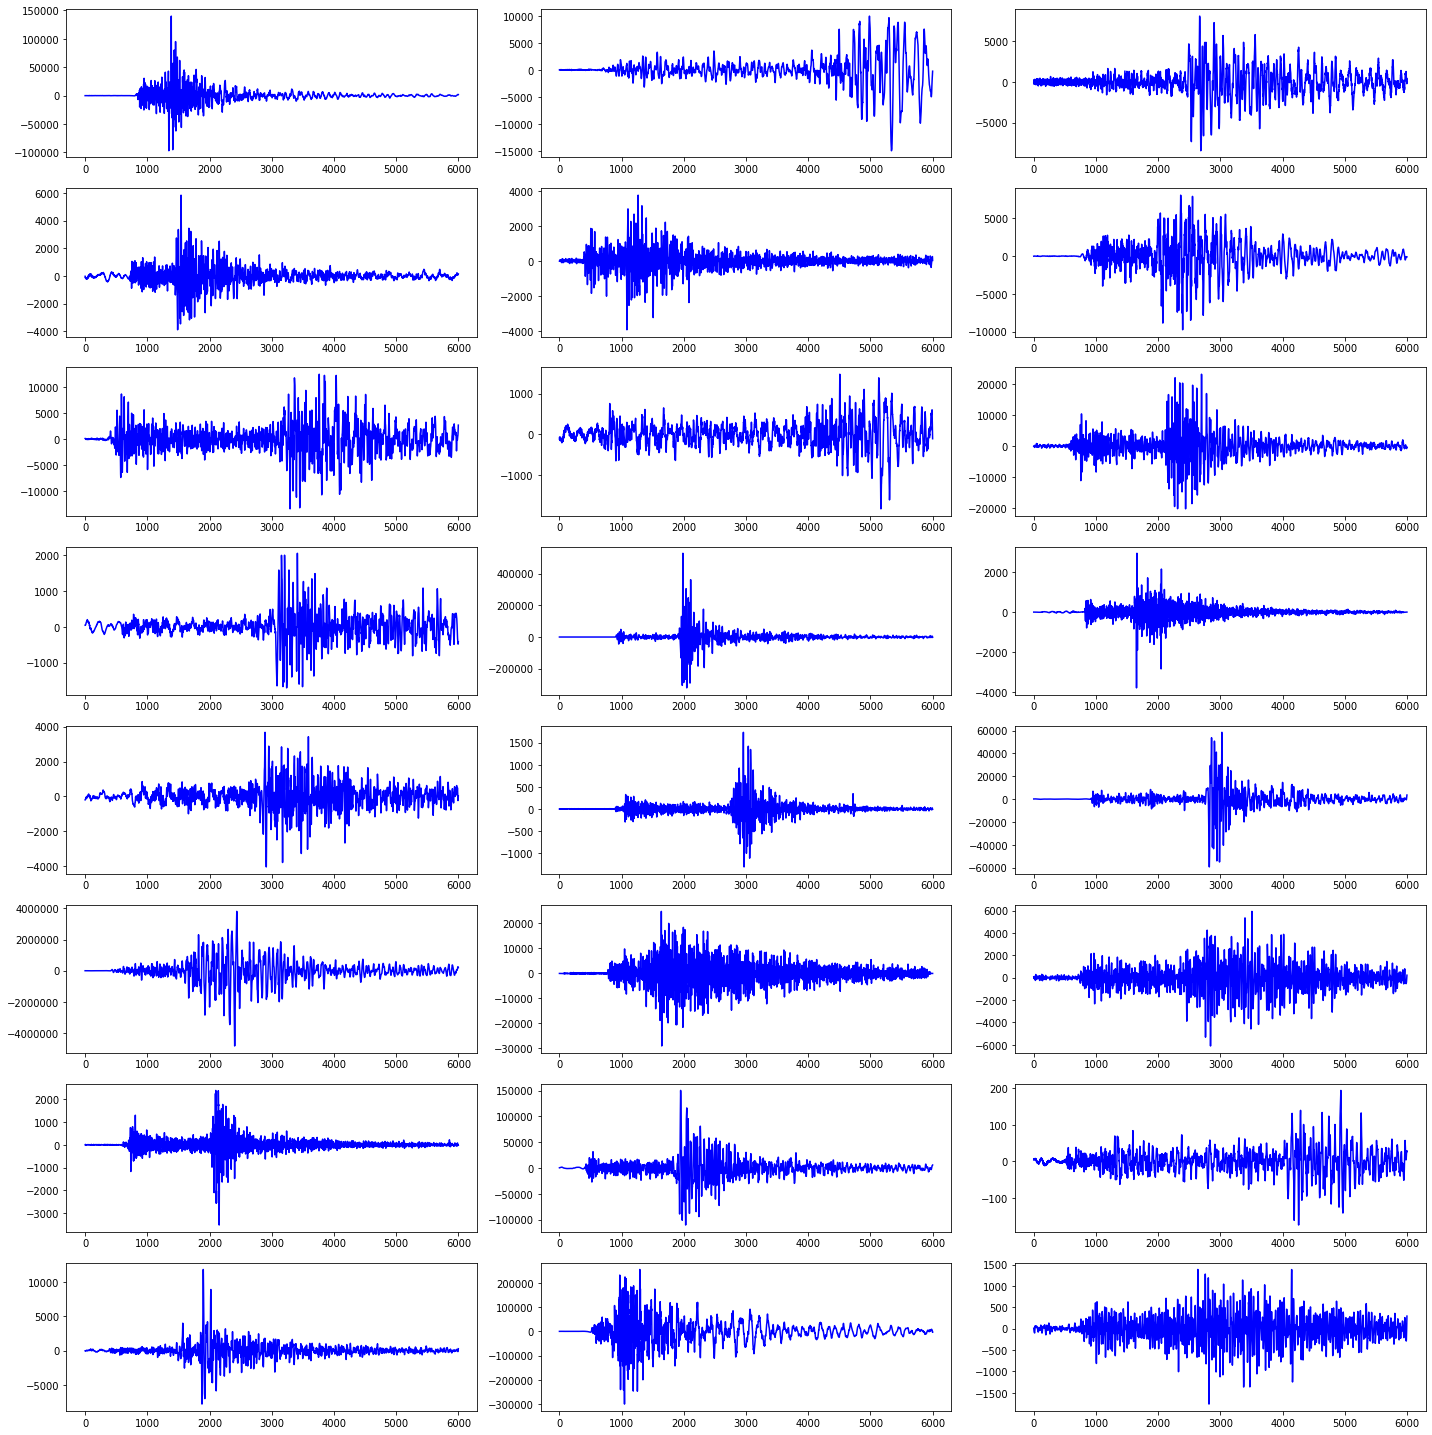

In [5]:
t_data = np.array([idx for idx, label in enumerate(test_label) if int(label) == 1])
plt.figure(figsize=(20, 20))
for i in tqdm(range(24)):
    plt.subplot(8, 3, i+1)
    plt.plot(test_inp[t_data[i]][0].to('cpu'), color='blue' if int(torch.round(test_outputs[t_data[i]])) == 1 else 'red')

plt.tight_layout()

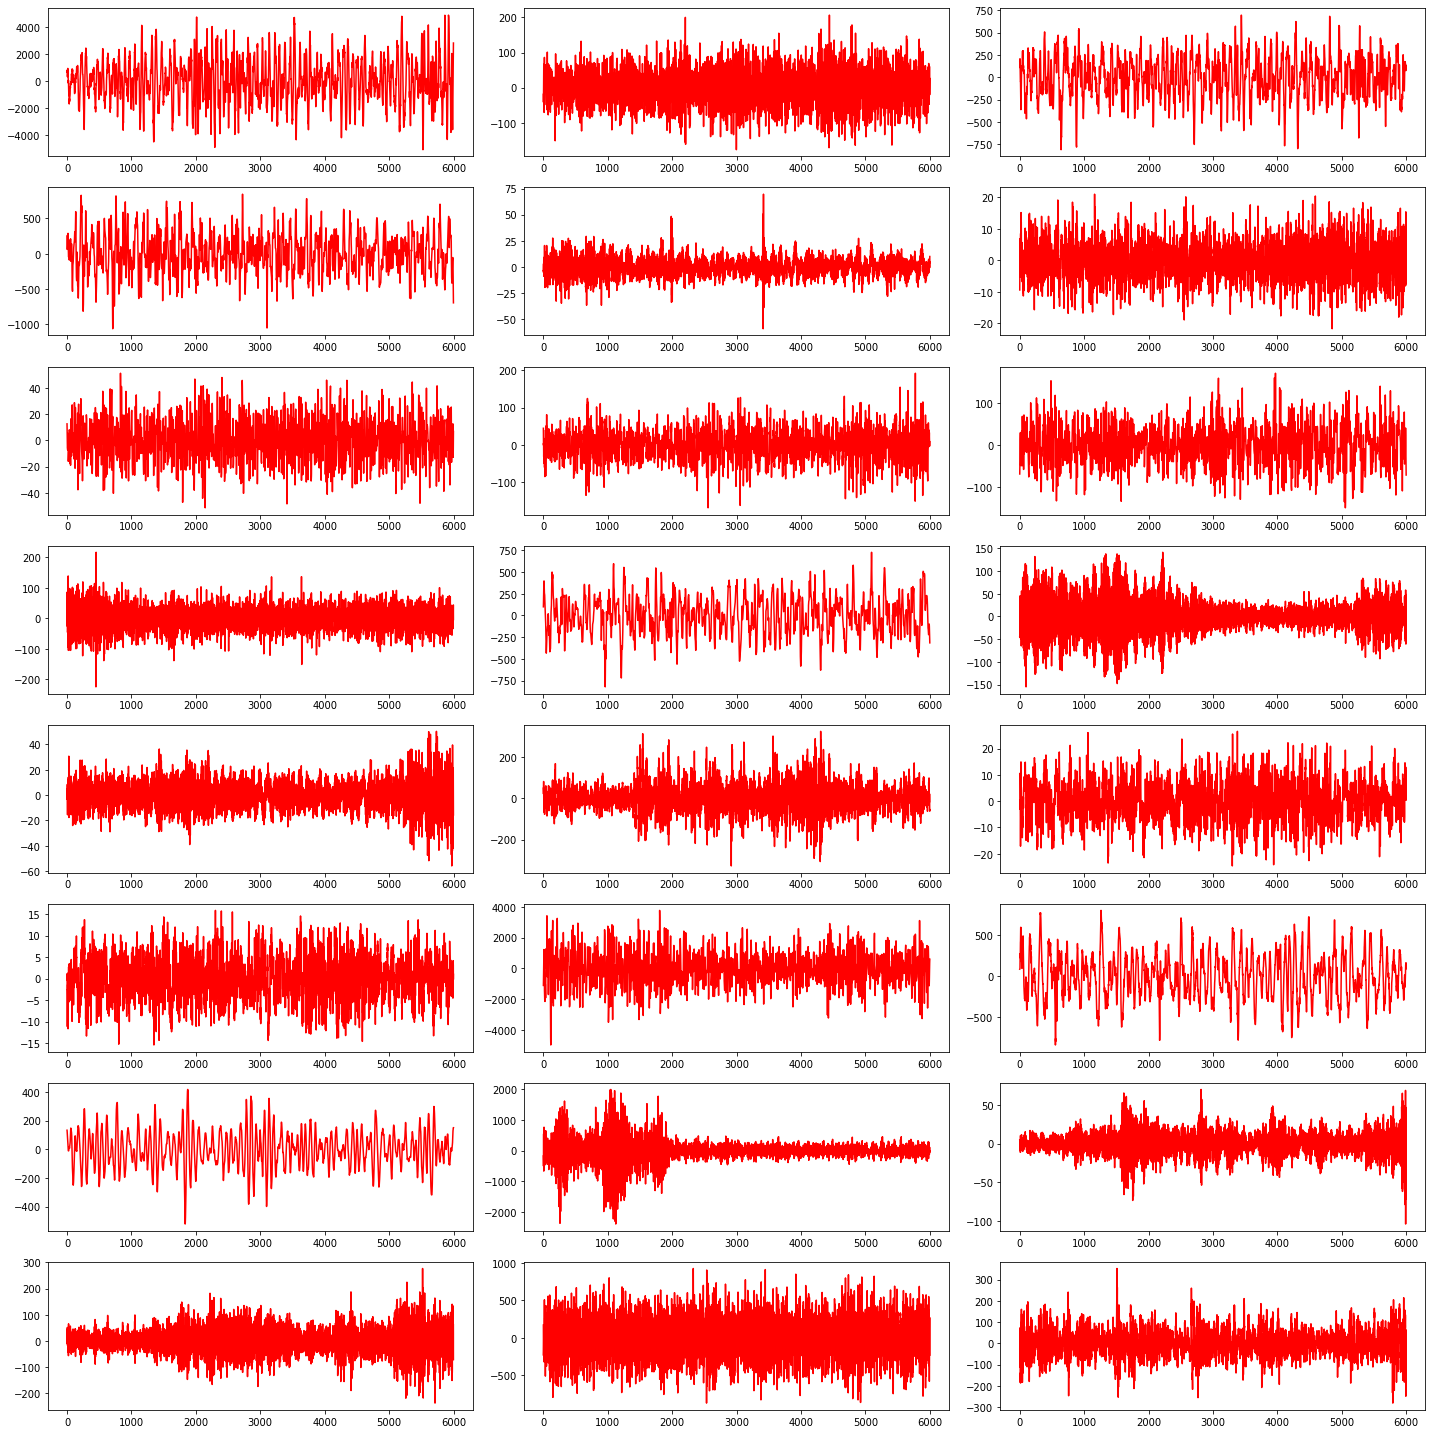

In [6]:
f_data = np.array([idx for idx, label in enumerate(test_label) if int(label) == 0])
plt.figure(figsize=(20, 20))
for i in tqdm(range(24)):
    plt.subplot(8, 3, i+1)
    plt.plot(test_inp[f_data[i]][0].to('cpu'), color='red' if int(torch.round(test_outputs[f_data[i]])) == 0 else 'blue')

plt.tight_layout()

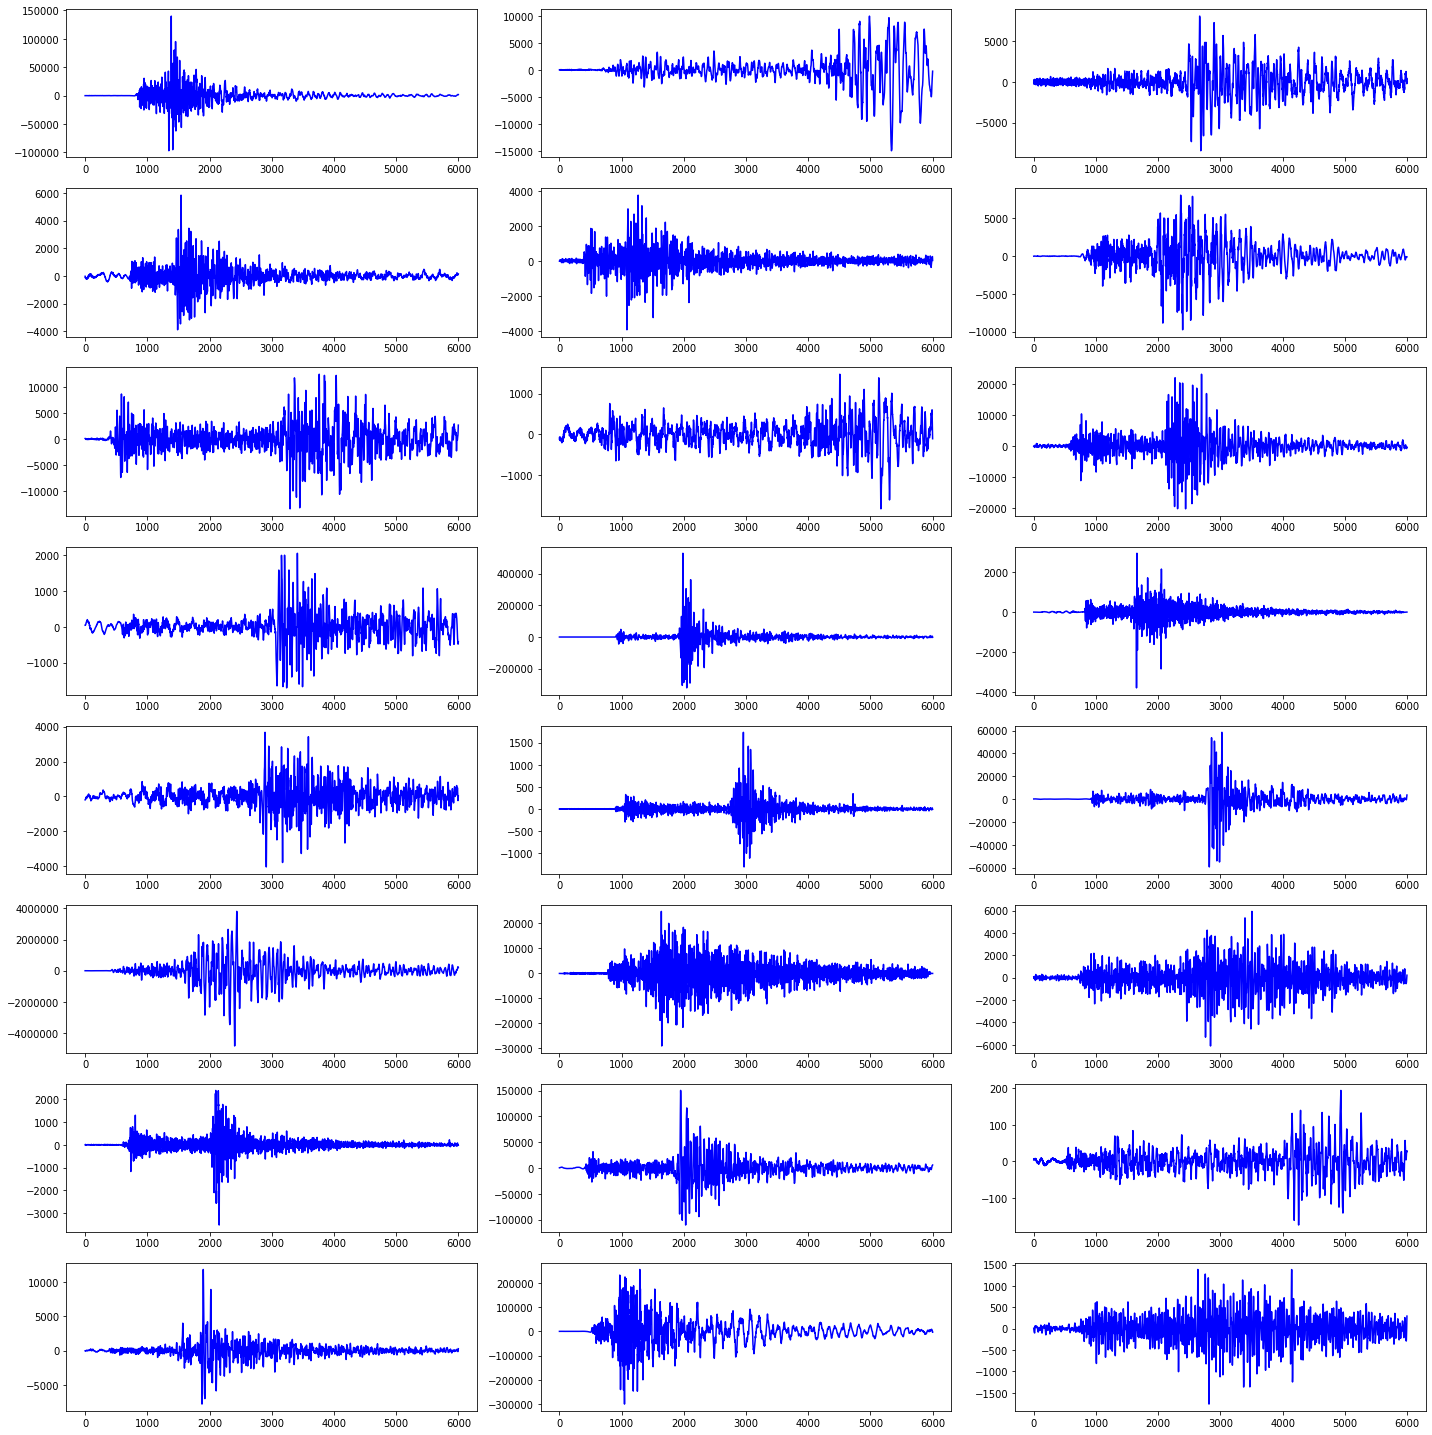

In [7]:
p_data = np.array([idx for idx, output in enumerate(test_outputs) if int(torch.round(output)) == 1])
plt.figure(figsize=(20, 20))
for i in tqdm(range(24)):
    plt.subplot(8, 3, i+1)
    plt.plot(test_inp[p_data[i]][0].to('cpu'), color='blue' if int(torch.round(test_label[p_data[i]])) == 1 else 'red')

plt.tight_layout()


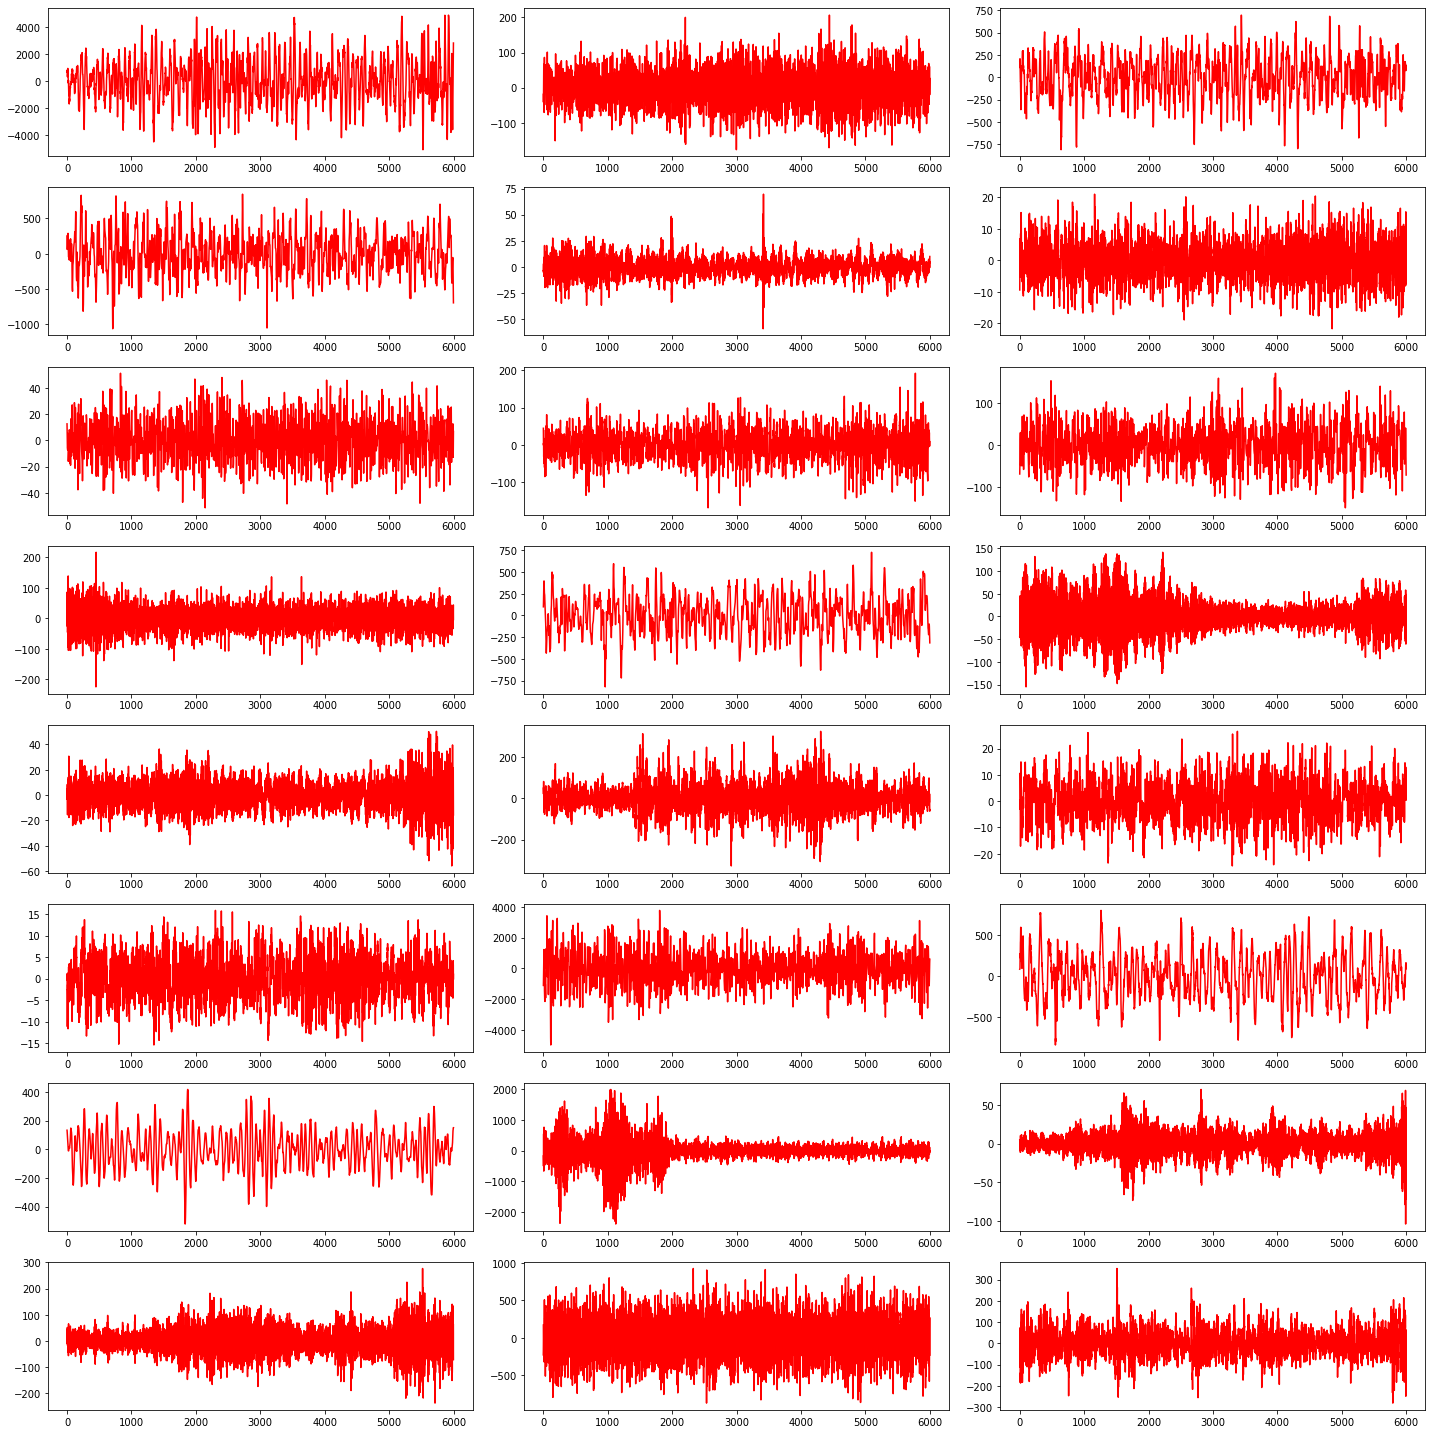

In [8]:
n_data = np.array([idx for idx, output in enumerate(test_outputs) if int(torch.round(output)) == 0])
plt.figure(figsize=(20, 20))
for i in tqdm(range(24)):
    plt.subplot(8, 3, i+1)
    plt.plot(test_inp[n_data[i]][0].to('cpu'), color='red' if int(torch.round(test_label[n_data[i]])) == 0 else 'blue')

plt.tight_layout()
